# Recommendations with IBM

This notebook will be putting recommendation systems to use on real data from the IBM Watson Studio platform. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [132]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [133]:
# explore df based on the example of an article_id, which is also present in df_content
df[df['article_id']==20].head()

,article_id,title,email
484,20.0,working interactively with rstudio and noteboo...,6a5863ef7766f57077af63df125d86a8314322a7
791,20.0,working interactively with rstudio and noteboo...,e685741240520687a02b033e21938ddf3acdab7f
2305,20.0,working interactively with rstudio and noteboo...,a4c700557b132cd82e8d781ad9ebbc73742e40b6
2745,20.0,working interactively with rstudio and noteboo...,9908795550380f852247fc193696de9c509f07d8
2767,20.0,working interactively with rstudio and noteboo...,aee3da889e6e79cbd017010d1ea24f30a81410d0


In [134]:
# show a similar article_id as for df, to get contextual understanding of data
df_content[df_content['article_id']==20].head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
20,Homepage Follow Sign in / Sign up Homepage * H...,It is often useful to use RStudio for one piec...,Working interactively with RStudio and noteboo...,Live,20


Below there will be some exploratory analysis for both datasets

In [135]:
df.count()

article_id    45993
title         45993
email         45976
dtype: int64

In [136]:
df_content.count()

doc_body           1042
doc_description    1053
doc_full_name      1056
doc_status         1056
article_id         1056
dtype: int64

In [137]:
# Get unique article_ids from both DataFrames
unique_ids_df = set(df['article_id'].unique())
unique_ids_df_content = set(df_content['article_id'].unique())

# Find the intersection of the two sets
common_unique_ids = unique_ids_df.intersection(unique_ids_df_content)

print(len(unique_ids_df))
print(len(unique_ids_df_content))
print(len(common_unique_ids))
print(common_unique_ids)

714
1051
437
{0.0, 2.0, 4.0, 8.0, 9.0, 12.0, 14.0, 15.0, 16.0, 18.0, 20.0, 25.0, 26.0, 28.0, 29.0, 30.0, 32.0, 33.0, 34.0, 36.0, 39.0, 40.0, 43.0, 48.0, 50.0, 51.0, 53.0, 54.0, 57.0, 58.0, 59.0, 60.0, 62.0, 64.0, 65.0, 68.0, 74.0, 76.0, 77.0, 78.0, 80.0, 81.0, 82.0, 87.0, 89.0, 92.0, 96.0, 98.0, 100.0, 101.0, 102.0, 103.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 115.0, 116.0, 117.0, 120.0, 122.0, 124.0, 125.0, 130.0, 131.0, 132.0, 134.0, 136.0, 138.0, 142.0, 143.0, 145.0, 146.0, 151.0, 152.0, 153.0, 157.0, 158.0, 162.0, 164.0, 173.0, 176.0, 181.0, 183.0, 184.0, 188.0, 189.0, 191.0, 193.0, 194.0, 195.0, 202.0, 205.0, 210.0, 213.0, 215.0, 221.0, 223.0, 224.0, 225.0, 230.0, 232.0, 233.0, 234.0, 236.0, 237.0, 239.0, 240.0, 241.0, 244.0, 250.0, 251.0, 252.0, 253.0, 254.0, 256.0, 258.0, 260.0, 263.0, 266.0, 268.0, 270.0, 273.0, 277.0, 278.0, 283.0, 284.0, 288.0, 291.0, 295.0, 297.0, 298.0, 299.0, 302.0, 303.0, 310.0, 311.0, 313.0, 314.0, 315.0, 316.0, 319.0, 323.0, 324.0, 329.0, 330

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Using the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Providing a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [138]:
# Count interactions per user
user_interactions_per_user = df['email'].value_counts()

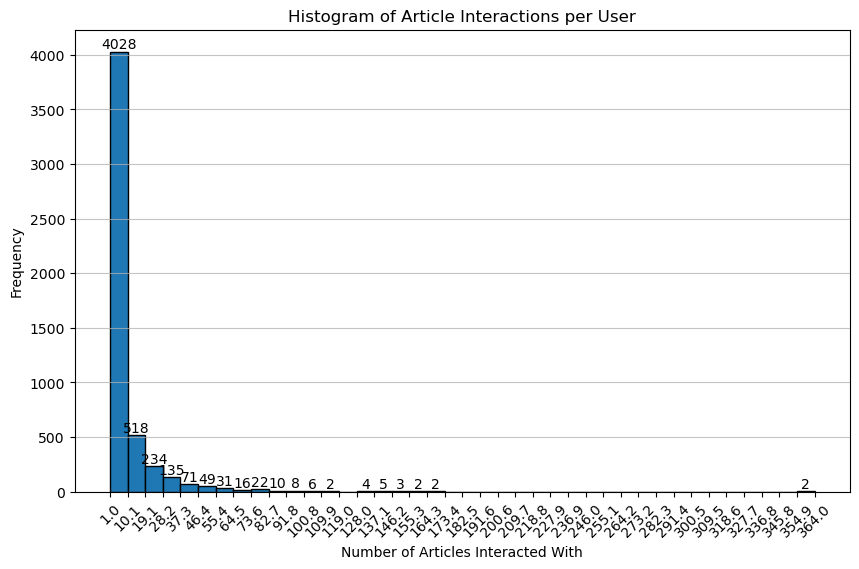

In [139]:
# Create a histogram of the number of articles interacted with

user_article_count_df = pd.DataFrame(user_interactions_per_user.reset_index())
user_article_count_df.columns = ['email', 'article_count']

# Step 2: Create a histogram of the article counts per user
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(user_article_count_df['article_count'], bins=40, edgecolor='black')

# Add counts on top of the bars
for count, x in zip(counts, bins):
    height = count
    if height > 0:
        plt.text(x + (bins[1] - bins[0]) / 2, height, int(height), ha='center', va='bottom')

# Set custom x-ticks to show the ending range of each bin
plt.xticks(bins, rotation=45)

plt.title('Histogram of Article Interactions per User')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [140]:
# Descriptive statistics
user_interactions_per_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: count, dtype: float64

**OBSERVATION 0** In majority of cases a user interacts with less than 10 article views.

As part of EDA, below there will be similar analysis but for number of unique articles per user and number of unique users per article

In [141]:
# Count the number of unique articles each user interacts with
user_article_count_df = df.groupby('email')['article_id'].nunique().reset_index()

# Rename the columns for clarity
user_article_count_df.columns = ['email', 'article_count']

# Display the new DataFrame
print(user_article_count_df.sort_values(by='article_count', ascending=False))

                                         email  article_count
910   2b6c0f514c2f2b04ad3c4583407dccd0810469ee            135
2426  77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a            135
4401  d9032ff68d0fd45dfd18c0c5f7324619bb55362c            101
4032  c60bb0a50c324dad0bffd8809d121246baef372b            100
3312  a37adec71b667b297ed2440a9ff7dad427c7ac85             97
...                                        ...            ...
550   1ab433bafebd7f8b6322c05def9b41e0f029ea83              1
2644  8283f83275dbd8cc8a2dd4d35a25f4a86310afbd              1
3938  c1ad3e68598e288e5df72275ba03444ee218aab8              1
551   1ab7c183ceb155cab3b9dcc92f36039b025cd86e              1
799   262b5095f21d3addbff0ab212a968a467cc7592b              1

[5148 rows x 2 columns]


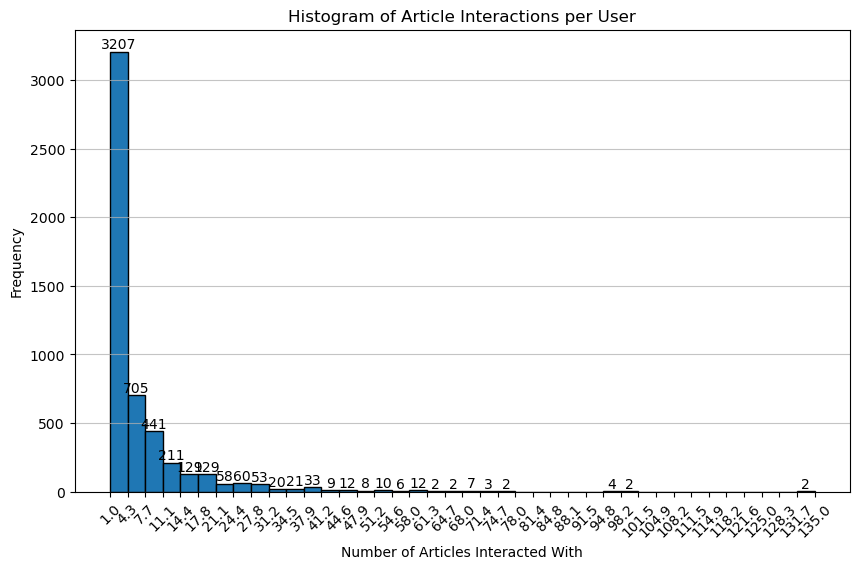

In [142]:
# Create a histogram of the article counts per user
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(user_article_count_df['article_count'], bins=40, edgecolor='black')

# Add counts on top of the bars
for count, x in zip(counts, bins):
    height = count
    if height > 0:
        plt.text(x + (bins[1] - bins[0]) / 2, height, int(height), ha='center', va='bottom')

# Set custom x-ticks to show the ending range of each bin
plt.xticks(bins, rotation=45)

plt.title('Histogram of Article Interactions per User')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**OBSERVATION 1** Majority of the users review less than 4 unique articles (~60%), while ~14% review between 4 and 8 articles per user. People rarely review more than 40 articles, and exceptional outliers are above 78 articles per user (only 8 occurences).

In [143]:
user_article_count_df.describe()

,article_count
count,5148.000000
mean,6.540210
std,9.990676
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,135.000000


**OBSERVATION 2** Descriptive statistics confirms that in 75% of the cases a user interacts with 7 or less unique articles on average, with high level of outliers.

In [144]:
# Converting article_id to a string for further integration with df_content
df['article_id'] = df['article_id'].astype(str)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  object
 1   title       45993 non-null  object
 2   email       45976 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [146]:
print(df)

      article_id                                              title  \
0         1430.0  using pixiedust for fast, flexible, and easier...   
1         1314.0       healthcare python streaming application demo   
2         1429.0         use deep learning for image classification   
3         1338.0          ml optimization using cognitive assistant   
4         1276.0          deploy your python model as a restful api   
...          ...                                                ...   
45988     1324.0                 ibm watson facebook posts for 2015   
45989      142.0  neural networks for beginners: popular types a...   
45990      233.0     bayesian nonparametric models – stats and bots   
45991     1160.0       analyze accident reports on amazon emr spark   
45992       16.0  higher-order logistic regression for large dat...   

                                          email  
0      ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1      083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b

In [147]:
# converting article_id column to the same format as in df
df_content['article_id'] = df_content['article_id'].astype(float).astype(str)

In [148]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   object
dtypes: object(5)
memory usage: 41.4+ KB


In [149]:
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046.0
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047.0
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048.0
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049.0


In [150]:
# Calculating median, maximum number of user_article interactios and mode below

median_val = user_article_count_df['article_count'].median()
max_views_by_user = df.groupby('email').size().reset_index(name='count')['count'].max()

print(f"50% of individuals interact with {median_val} number of articles or fewer.")
print(f"The maximum number of user-article interactions by any 1 user is  {max_views_by_user}")
print(f"Mode of number of articles per user: {user_article_count_df['article_count'].mode().values}")

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is  364
Mode of number of articles per user: [1]


`1b.` What is the distribution of how many unique users per article in the dataset? Providing a visual and descriptive statistics to assist with giving a look at the number of users interacted per article.  

In [151]:
# Group by article_id and count the number of emails
email_count_df = df.groupby('article_id')['email'].count().reset_index()

# Rename the columns for clarity
email_count_df.columns = ['article_id', 'email_count']

# Display the new DataFrame
print(email_count_df.sort_values(by='email_count', ascending=False))

    article_id  email_count
311     1429.0          937
232     1330.0          927
314     1431.0          671
309     1427.0          643
261     1364.0          627
..         ...          ...
154     1200.0            1
572      675.0            1
75      1119.0            1
244     1344.0            1
64      1092.0            1

[714 rows x 2 columns]


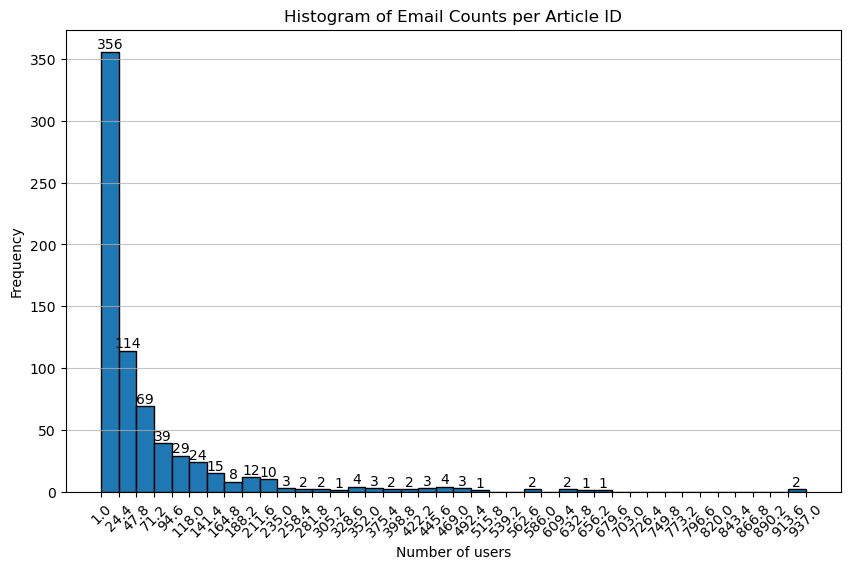

In [152]:
# Create a histogram of the email counts
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(email_count_df['email_count'], bins=40, edgecolor='black')

# Add counts on top of the bars
for count, x in zip(counts, bins):
    height = count
    # Check if the height is greater than 0 to avoid placing text on empty bars
    if height > 0:
        plt.text(x + (bins[1] - bins[0]) / 2, height, int(height), ha='center', va='bottom')

plt.xticks(bins, rotation=45)

plt.title('Histogram of Email Counts per Article ID')
plt.xlabel('Number of users')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**OBSERVATION 3** There are only 2 exceptional articles, which attracted more than 900 users. Majority of articles (~50%) attracted less than 25 users.

In [153]:
email_count_df['email_count'].describe()

count    714.000000
mean      64.392157
std      109.161462
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: email_count, dtype: float64

**OBSERVATION 4** 75% or less of articles attracted (were read by) less than 70 unique users.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [154]:
# Finding and exploring duplicate articles
duplicates = df_content[df_content.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [doc_body, doc_description, doc_full_name, doc_status, article_id]
Index: []


**Note 1** No duplicates found

In [155]:
# Removing any rows that have the same article_id - only keep the first

In [156]:
# count of rows with the same article_ids
print(df_content.count())

doc_body           1042
doc_description    1053
doc_full_name      1056
doc_status         1056
article_id         1056
dtype: int64


In [157]:
# Remove duplicate rows based on 'article_id', keeping the first occurrence
df_content_unique = df_content.drop_duplicates(subset='article_id', keep='first')

# Count of rows without the same article_id
print(df_content_unique.count())

doc_body           1037
doc_description    1048
doc_full_name      1051
doc_status         1051
article_id         1051
dtype: int64


**OBSERVATION 5** df_content had 5 rows with the same article_id

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [158]:
# Merge the DataFrames on article_id
merged_df = pd.merge(df, df_content_unique, on='article_id', how='inner')

# Get unique users who viewed articles from df_content
unique_users = merged_df['email'].unique()

# Convert to a list if needed
unique_users_list = unique_users.tolist()

In [159]:
# removing null email cases
df_no_null=df[df['email'].notnull() & (df['email'] != '')]

In [160]:
unique_articles = len(set(df['article_id'].unique()))# The number of unique articles that have at least one interaction
total_articles = len(set(df_content_unique['article_id'].unique())) # The number of unique articles on the IBM platform
unique_users = len(set(df_no_null['email'].unique()))# The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions
user_article_count = len(common_unique_ids)

print(f"The number of unique articles that have at least one interaction: {unique_articles}.")
print(f"The number of unique articles on the IBM platform: {total_articles}.")
print(f"The number of unique users: {unique_users}.")
print(f"The number of user-article interactions: {user_article_interactions}.")
print(f"The number of unique user-article interactions: {user_article_count}.")

The number of unique articles that have at least one interaction: 714.
The number of unique articles on the IBM platform: 1051.
The number of unique users: 5148.
The number of user-article interactions: 45993.
The number of unique user-article interactions: 437.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [161]:
# Group by article_id and count the number of emails
email_count_df = df.groupby('article_id')['email'].count().reset_index()

# Rename the columns for clarity
email_count_df.columns = ['article_id', 'email_count']

# Display the new DataFrame
print(email_count_df.sort_values(by='email_count', ascending=False))

    article_id  email_count
311     1429.0          937
232     1330.0          927
314     1431.0          671
309     1427.0          643
261     1364.0          627
..         ...          ...
154     1200.0            1
572      675.0            1
75      1119.0            1
244     1344.0            1
64      1092.0            1

[714 rows x 2 columns]


In [162]:
most_viewed_article_id = email_count_df.sort_values(by='email_count', ascending=False).head(1)['article_id'].values[0] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = email_count_df.sort_values(by='email_count', ascending=False).head(1)['email_count'].values[0]# The most viewed article in the dataset was viewed how many times?

print(f"The most viewed article in the dataset as a string with one value following the decimal: {most_viewed_article_id}")
print(f"The most viewed article in the dataset was viewed how many times?: {max_views}")

The most viewed article in the dataset as a string with one value following the decimal: 1429.0
The most viewed article in the dataset was viewed how many times?: 937


In [163]:
# Running this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [164]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in some cases, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  object
 1   title       45993 non-null  object
 2   user_id     45993 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [166]:
print(df.groupby('article_id').size().reset_index(name='count')['count'].max())

937


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  object
 1   title       45993 non-null  object
 2   user_id     45993 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [168]:
# testing environment for top 5
top_5_articles = df['article_id'].value_counts().head(10)

# Prepare a list to hold the results
results = []

for article_id, count in top_5_articles.items():
    title = df.loc[df['article_id'] == article_id, 'title'].values[0]
    results.append((article_id, title, count))

for article_id, title, count in results:
    print(f'Article ID: {article_id}, Title: {title}, Count: {count}')

Article ID: 1429.0, Title: use deep learning for image classification, Count: 937
Article ID: 1330.0, Title: insights from new york car accident reports, Count: 927
Article ID: 1431.0, Title: visualize car data with brunel, Count: 671
Article ID: 1427.0, Title: use xgboost, scikit-learn & ibm watson machine learning apis, Count: 643
Article ID: 1364.0, Title: predicting churn with the spss random tree algorithm, Count: 627
Article ID: 1314.0, Title: healthcare python streaming application demo, Count: 614
Article ID: 1293.0, Title: finding optimal locations of new store using decision optimization, Count: 572
Article ID: 1170.0, Title: apache spark lab, part 1: basic concepts, Count: 565
Article ID: 1162.0, Title: analyze energy consumption in buildings, Count: 512
Article ID: 1304.0, Title: gosales transactions for logistic regression model, Count: 483


In [169]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Get the top 'n' article IDs based on their counts
    top_5_articles = df['article_id'].value_counts().head(n)

    # Prepare a list to hold the top article titles
    top_articles = []

    for article_id in top_5_articles.index:
        title = df.loc[df['article_id'] == article_id, 'title'].values[0]
        top_articles.append(title)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Get the top 'n' article IDs based on their counts
    top_5_articles = df['article_id'].value_counts().head(n)

    # Prepare a list to hold the top article IDs
    top_articles = list(top_5_articles.index)
 
    return top_articles # Return the top article ids

In [170]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [171]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Using the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then placing a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Using the tests to make sure the basic structure of matrix matches what is expected by the solution.

In [172]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create the user-item matrix using pivot_table
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc='size', fill_value=0)

    # Convert counts to binary (1 for interaction, 0 otherwise)
    user_item[user_item > 0] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [173]:
## Tests: 
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Completing the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [174]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # Compute the dot product of the specified user with all other users
    user_vector = user_item.loc[user_id]
    similarity_scores = user_item.dot(user_vector)

    # Sort by similarity scores in descending order
    most_similar_users = similarity_scores.sort_values(ascending=False)

    # Create a list of just the user ids, excluding the input user_id
    similar_users = most_similar_users.index[most_similar_users.index != user_id].tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [175]:
# Doing a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: user_id
1       36
3933    35
23      17
3782    17
203     15
4459    15
3870    14
131     14
4201    13
46      13
dtype: int64
The 5 most similar users to user 3933 are: user_id
1       35
3933    35
23      17
3782    17
203     15
dtype: int64
The 3 most similar users to user 46 are: user_id
46      40
4201    40
3782    26
dtype: int64


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.  Completing the functions below to return the articles we would recommend to each user. 

In [176]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Use the DataFrame to get the titles corresponding to the article_ids
    article_names = df[df['article_id'].isin(article_ids)]['title'].tolist()

    # Remove duplicates by converting to a set and back to a list
    article_names = list(set(article_names))

    return article_names # Return the article names associated with list of article ids 

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
     # Get the article IDs that the user has interacted with
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    
    # Get the article names using the get_article_names function
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get the articles the user has already seen
    seen_articles, _ = get_user_articles(user_id)
    
    # Get similar users
    similar_users = find_similar_users(user_id)
    
    # Prepare a set for recommendations to avoid duplicates
    recs_set = set()

    # Loop through similar users
    for similar_user in similar_users:
        # Get articles that the similar user has seen
        similar_user_articles, _ = get_user_articles(similar_user)
        
        # Filter out articles that the target user has already seen
        new_articles = [article for article in similar_user_articles if article not in seen_articles]
        
        # Add new articles to the recommendations set
        recs_set.update(new_articles)

        # Stop if we have enough recommendations
        if len(recs_set) >= m:
            break
    
    # Convert the set back to a list and limit to m
    recs = list(recs_set)[:m]
    
    # Get article names for the recommended article IDs
    rec_names = get_article_names(recs, df)
    
    # # Get the articles the user has already seen
    # seen_articles, _ = get_user_articles(user_id)
    
    # # Get similar users
    # similar_users = find_similar_users(user_id)
    
    # # Prepare a list for recommendations
    # recs = []

    # # Loop through similar users
    # for similar_user in similar_users:
    #     # Get articles that the similar user has seen
    #     similar_user_articles, _ = get_user_articles(similar_user)
        
    #     # Filter out articles that the target user has already seen
    #     new_articles = [article for article in similar_user_articles if article not in seen_articles]
        
    #     # Add new articles to recommendations
    #     recs.extend(new_articles)

    #      # Stop if we have enough recommendations
    #     if len(recs) >= m:
    #         break
    
    # # Get unique recommendations and limit to m
    # recs = list(set(recs))[:m]
    
    # # Get article names for the recommended article IDs
    # recs = get_article_names(recs, df)
    
    return recs # return your recommendations for this user_id    

In [177]:
user_user_recs(1, 10)

['1053.0',
 '943.0',
 '1162.0',
 '1330.0',
 '1405.0',
 '316.0',
 '1184.0',
 '486.0',
 '482.0',
 '1425.0']

In [178]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'insights from new york car accident reports',
 'access mysql with python',
 'discover hidden facebook usage insights',
 'using deep learning with keras to predict customer churn',
 'use spark r to load and analyze data',
 'leverage python, scikit, and text classification for behavioral profiling',
 'city population by sex, city and city type',
 'uci: heart disease - cleveland',
 'use spark for r to load data and run sql queries']

In [179]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choosing the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choosing articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function we wrote earlier.

In [180]:
def get_top_sorted_users2(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Compute similarity scores for all
    similarity = user_item.dot(user_item.loc[user_id])

    # Get the number of interactions each user has
    num_interactions = df.groupby('user_id').count()['article_id']

    # Create a DataFrame for neighbors
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values,
        'num_interactions': num_interactions.values
    })

    # Remove the user_id from the neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]

    # Sort by similarity and then by number of interactions
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)

    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    global df, user_item  # Declare df and user_item as global variables

    # Get the articles the user has already seen
    seen_articles, _ = get_user_articles(user_id)

    # Get sorted neighbors
    neighbors_df = get_top_sorted_users2(user_id, df, user_item)

    # Prepare a list for recommendations
    recs = []

    # Get article interactions
    article_interactions = df.groupby('article_id').count()['user_id']

    # Loop through similar users based on sorted order
    for neighbor in neighbors_df['neighbor_id']:
        # Get articles that the similar user has seen
        neighbor_seen_articles, _ = get_user_articles(neighbor)

        # Filter out articles that the target user has already seen
        new_articles = np.setdiff1d(neighbor_seen_articles, seen_articles)

        # Count interactions for each new article
        new_article_counts = article_interactions.loc[new_articles].sort_values(ascending=False).index.tolist()

        # Add sorted articles to recommendations until we reach m
        for article in new_article_counts:
            if len(recs) < m:
                recs.append(article)
            else:
                break
        
        # Stop if we have enough recommendations
        if len(recs) >= m:
            break

    # Get unique recommendations and limit to m
    recs = list(set(recs))[:m]
    
    # Get article names for the recommended article IDs
    rec_names = get_article_names(recs, df)

    return recs, rec_names

In [181]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1427.0', '1170.0', '1351.0', '1330.0', '1162.0', '1354.0', '1364.0', '1160.0', '1304.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['putting a human face on machine learning', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports', 'model bike sharing data with spss', 'movie recommender system with spark machine learning', 'gosales transactions for logistic regression model', 'analyze accident reports on amazon emr spark', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm']


`5.` Use the functions from above to correctly fill in the solutions to the dictionary below.  Then test dictionary against the solution. Providing the code we need to answer each following the comments below.

In [182]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    # Compute similarity scores for all users
    user_vector = user_item.loc[user_id]
    similarity_scores = user_item.dot(user_vector)

    # Create a DataFrame for neighbors
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity_scores.index,
        'similarity': similarity_scores.values,
        'num_interactions': user_item.sum(axis=1)  # Total interactions for each user
    })

    # Remove the user_id from the neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]

    # Sort by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
   
    return neighbors_df 

In [183]:
### Tests with a dictionary of results
neighbors_df_user1 = get_top_sorted_users(1)
user1_most_sim = neighbors_df_user1.iloc[0]['neighbor_id']  # Find the user that is most similar to user 1 

neighbors_df_user131 = get_top_sorted_users(131)
user131_10th_sim = neighbors_df_user131.iloc[10]['neighbor_id'] # Find the 10th most similar user to user 131

In [184]:
# Create the dictionary with the results
results_dict = {
    'user1_most_sim': user1_most_sim,
    'user131_10th_sim': user131_10th_sim
}

# Print the results
print(results_dict)

{'user1_most_sim': 3933, 'user131_10th_sim': 242}


In [185]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Response:** Rank-Based Recommendations (via get_top_articles function for example) would be a better choice for new users vs Collaborative Filtering Based Recommendations, as we don't have yet a user history and we can assume that "top articles" should be the most interesting ones for a general user.

Knowledge-Based Recommendations would be the other great choice, if a user already indicated certain areas of interests during the inception phase (registration).

The other option could be to provide Rank-Based Recommendations per content, indicated by a user as a preferred one (a hybrid combination of Rank-Based and Knowledge-Based Recommendations). In that way we can be closer to the customization, while having absence of the history of interactions by a new user.

`7.` Using your existing functions, providing the top 10 recommended articles we would provide for the a new user below. It can be tested the function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [186]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)

In [187]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


#### <a class="anchor" id="Content-Recs">Part IV: optional part was skipped</a>

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [188]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [189]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [190]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

# Display the shapes of the resulting matrices
print("U matrix shape:", u.shape)
print("S matrix shape:", s.shape)
print("VT matrix shape:", vt.shape)

U matrix shape: (5149, 714)
S matrix shape: (714,)
VT matrix shape: (714, 714)


**Response** In the lesson we have used Funk SVD, which is useful when dealing with many missing values. While the current user - item matrix has 0 / 1 and we don't need to use Funk SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [191]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    # err = np.sum(np.sum(np.abs(diffs), axis=0), axis=0)
    sum_errs.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


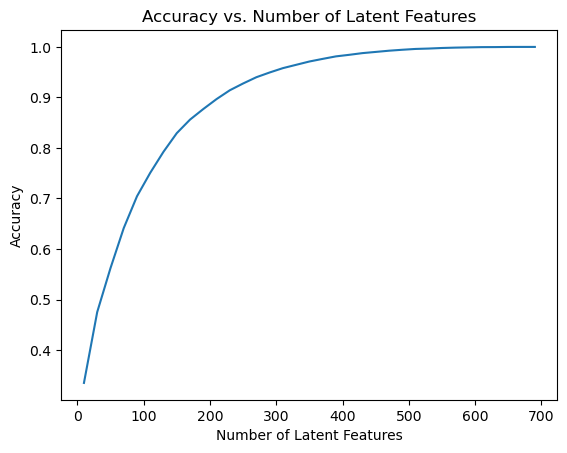

In [192]:
plt.show()  

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [193]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    shared_idx = list(train_idx.intersection(test_idx))
    
    train_arts = set(user_item_train.columns)
    test_arts =  set(user_item_test.columns)
    shared_cols = list(train_arts.intersection(test_arts))

    user_item_test = user_item_test.loc[shared_idx, shared_cols]

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

# Output the results
print("User-item matrix for training set shape:", user_item_train.shape)
print("User-item matrix for testing set shape:", user_item_test.shape)
print("Number of users in test set:", len(test_idx))
print("Number of articles in test set:", len(test_arts))

User-item matrix for training set shape: (4487, 714)
User-item matrix for testing set shape: (20, 574)
Number of users in test set: 682
Number of articles in test set: 574


In [194]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [195]:
# fit SVD on the user_item_train matrix

u_train, s_train, vt_train = np.linalg.svd(np.array(user_item_train, dtype='int'), full_matrices=False)

# Display the shapes of the resulting matrices
print("U matrix shape:", u_train.shape)
print("S matrix shape:", s_train.shape)
print("VT matrix shape:", vt_train.shape)

U matrix shape: (4487, 714)
S matrix shape: (714,)
VT matrix shape: (714, 714)


In [196]:
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

In [197]:
num_latent_feats = np.arange(0,700+10,20)
sum_error_train = []
sum_error_test = []
total_error = []

for k in num_latent_feats:
    # restructure matrices using k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # calculate predictions by taking the dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    total_error.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
        
    # compute the difference between actual and predicted values
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # calculate total errors and store them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_error_train.append(err_train)
    sum_error_test.append(err_test)
        
plt.plot(num_latent_feats, 1 - np.array(sum_error_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_error_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.plot(num_latent_feats, total_error, label='Total');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


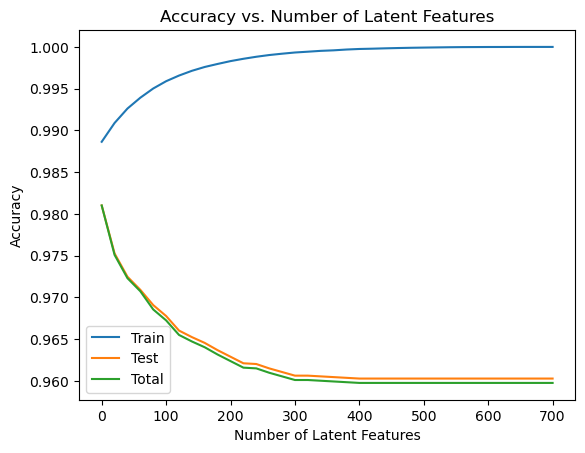

In [198]:
plt.show()

`6.` Using the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discussing what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Response**

Training Accuracy: As the number of latent features increases, the training accuracy approaches 1.0. This indicates that the model is able to well reconstruct the training data when a sufficient number of latent features is used. However, this suggests overfitting, where the model learns the training data too well, capturing noise and specific patterns that do not generalize to new data.

Testing Accuracy: The testing accuracy decreases as the number of latent features increases. This drop in accuracy suggests that the model is overfitting to the training data and not generalizing well to the test data. This may be due to a lack of variety in the training dataset, leading to a model that cannot capture the broader patterns needed for accurate predictions on unseen data.

Overall Accuracy: The total accuracy shows a similar trend to the test accuracy, decreasing as more latent features are used.

To improve the generalization of the model, we could move/change the data more thoroughly before splitting it into training and testing sets. 

We can do the following to further assess effectiveness of the recommendation system:
- analyze engagement metrics, e.g. how much time a user spends reading articles, how many from the recommended list a user decided to interact with, how many articles was shared, saved, repetitively accessed (returned user for the same article) etc.
- conducting A/B testing on using SVD-based system and without; OR other methods to compare recommendation systems,
- conduct a survey / gather feedback for power users on the effectiveness of the recommendation system.